# inter-run comparisons of N contained in phytoplankton
    - S3
    - Sentry Shoal
    - Central Node
    - JDF

In [1]:
import pandas as pd
import netCDF4 as nc
import datetime as dt
import subprocess
import requests
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import re
import dateutil as dutil
from salishsea_tools import viz_tools, places
import glob
import pickle
import matplotlib.dates as mdates
import matplotlib as mpl
import h5py
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=16) 
mpl.rc('legend', fontsize=16) 
mpl.rc('axes', titlesize=16) 
mpl.rc('figure', titlesize=16) 
mpl.rc('axes', labelsize=16) 
mpl.rc('font', size=16) 

mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.numpoints'] = 1
%matplotlib inline

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plist=['Sentry Shoal','S3','Central node','Central SJDF']

In [3]:
df1=pd.read_csv('/ocean/eolson/MEOPAR/obs/ONC/turbidity/nearSurface/search3928586/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20140804T234330Z_20150604T070614Z-clean.csv',
        skiprows=78,header=None,
        names=('TimeUTC','CDOM','CDOMQC','Chlorophyll_ug','ChlQC','Turbidity_NTU','TurbQC','Lat','LatQC','Lon','LongQC'))

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df2=pd.read_csv('/ocean/eolson/MEOPAR/obs/ONC/turbidity/nearSurface/search3928586/BritishColumbiaFerries_Tsawwassen-DukePoint_Turbidity-ChlorophyllandFluorescence_20150604T070624Z_20160307T160206Z-clean.csv',
        skiprows=78,header=None,
        names=('TimeUTC','CDOM','CDOMQC','Chlorophyll_ug','ChlQC','Turbidity_NTU','TurbQC','Lat','LatQC','Lon','LongQC'))

/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (1,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df=pd.concat([df1.drop(df1[df1.TimeUTC<'2015'].index),df2.drop(df2[df2.TimeUTC>'2016'].index)],ignore_index=True)

In [6]:
dts=[dt.datetime(int(r[0:4]),int(r[5:7]),int(r[8:10]),int(r[11:13]),int(r[14:16]),int(r[17:19])) for r in df['TimeUTC']]

In [7]:
df=df.assign(dts=dts)

In [8]:
df2=df.loc[(df.dts>=dt.datetime(2015,3,1))&(df.dts<dt.datetime(2015,4,1))].copy()
df=df2

In [9]:
df['Day']=[dt.datetime(2015,3,1+int(np.floor((ii-dt.datetime(2015,3,1)).days)),12,0,0) for ii in df['dts']]

In [10]:
df['Lat']=pd.to_numeric(df['Lat'],errors='coerce')
df['Lon']=pd.to_numeric(df['Lon'],errors='coerce')

df['Chlorophyll_ug']=pd.to_numeric(df['Chlorophyll_ug'],errors='coerce')

In [11]:
df.head()

,TimeUTC,CDOM,CDOMQC,Chlorophyll_ug,ChlQC,Turbidity_NTU,TurbQC,Lat,LatQC,Lon,LongQC,dts,Day
73737,2015-03-07T08:00:02.003Z,16.6804,1,18.5372,1,4.7864,1,49.052465,8,-123.397316,8,2015-03-07 08:00:02,2015-03-07 12:00:00
73738,2015-03-07T08:00:12.178Z,16.948,1,18.0895,1,4.4776,1,49.051939,8,-123.396113,8,2015-03-07 08:00:12,2015-03-07 12:00:00
73739,2015-03-07T08:00:22.363Z,16.948,1,17.2788,1,4.4776,1,49.051247,8,-123.395074,8,2015-03-07 08:00:22,2015-03-07 12:00:00
73740,2015-03-07T08:00:32.547Z,17.2156,1,17.2788,1,4.246,1,49.050738,8,-123.393852,8,2015-03-07 08:00:32,2015-03-07 12:00:00
73741,2015-03-07T08:00:41.590Z,17.2156,1,16.7222,1,4.4776,1,49.050287,8,-123.392776,8,2015-03-07 08:00:41,2015-03-07 12:00:00


In [12]:
dfM=df.groupby(['Day']).mean().reset_index()

In [13]:
dfM.head()

,Day,CDOMQC,Chlorophyll_ug,ChlQC,TurbQC,Lat,LatQC,Lon,LongQC
0,2015-03-07 12:00:00,1.0,8.949577,1.0,1.0,49.113819,8.003353,-123.528560,8.003353
1,2015-03-08 12:00:00,1.0,11.767839,1.0,1.0,49.103850,8.005698,-123.487868,8.005698
2,2015-03-09 12:00:00,1.0,18.949815,1.0,1.0,49.115309,8.003215,-123.529631,8.003215
3,2015-03-10 12:00:00,1.0,18.218696,1.0,1.0,49.120347,8.004432,-123.543962,8.004432
4,2015-03-11 12:00:00,1.0,22.396780,1.0,1.0,49.116122,8.003529,-123.529008,8.003529


In [14]:
places.PLACES['S3']

{'GEM2.5 grid ji': (138, 144),
 'NEMO grid ji': (450, 258),
 'lon lat': (-123.558, 49.125)}

In [15]:
111*.0226

2.5086

In [16]:
llon=places.PLACES['S3']['lon lat'][0]-.01
ulon=places.PLACES['S3']['lon lat'][0]+.01
llat=places.PLACES['S3']['lon lat'][1]-.01
ulat=places.PLACES['S3']['lon lat'][1]+.01
iidfnd=(df.Lon>llon)&(df.Lon<ulon)&(df.Lat>llat)&(df.Lat<ulat)

(datetime.datetime(2015, 3, 6, 0, 0), datetime.datetime(2015, 3, 16, 0, 0))

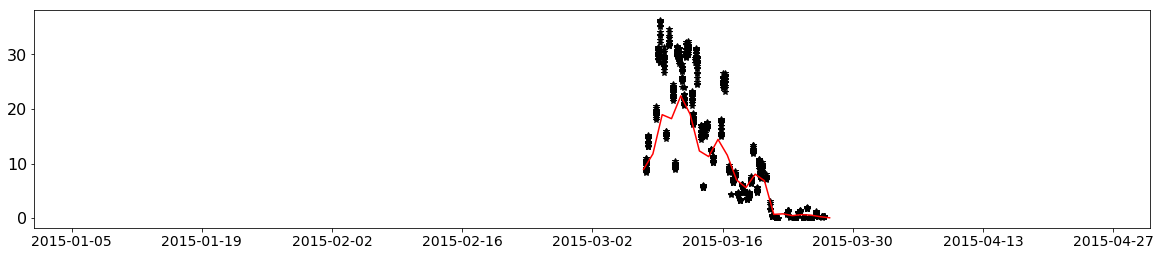

In [17]:
fig,ax=plt.subplots(1,1,figsize=(20,4))
ax.plot(df.loc[iidfnd,['dts']],df.loc[iidfnd,['Chlorophyll_ug']],'k*')
ax.plot(dfM['Day'],dfM['Chlorophyll_ug'],'r-')
ax.set_xlim(dt.datetime(2015,1,1),dt.datetime(2015,5,1))
dt.datetime(2014,12,31)+dt.timedelta(days=65),dt.datetime(2014,12,31)+dt.timedelta(days=75)


In [18]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    tmask=np.copy(fm.variables['tmask'])
    umask=np.copy(fm.variables['umask'])
    vmask=np.copy(fm.variables['vmask'])
    navlon=np.copy(fm.variables['nav_lon'])
    navlat=np.copy(fm.variables['nav_lat'])
    e3t_0=np.copy(fm.variables['e3t_0'])
    e3u_0=np.copy(fm.variables['e3u_0'])
    e3v_0=np.copy(fm.variables['e3v_0'])
    e1t=np.copy(fm.variables['e1t'])
    e2t=np.copy(fm.variables['e2t'])
    e1v=np.copy(fm.variables['e1v'])
    e2u=np.copy(fm.variables['e2u'])
    A=fm.variables['e1t'][0,:,:]*fm.variables['e2t'][0,:,:]*tmask[0,0,:,:]

t0=dt.datetime(2015,2,6)
fdur=10 # length of each results file in days
fnum=18 # number of results files per run
runlen=fdur*fnum # length of run in days
#stm=np.shape(tmask)

In [19]:
saveloc='/data/eolson/MEOPAR/SS36runs/calcFiles/comparePhytoN/'
baseloc='/data/eolson/MEOPAR/SS36runs/CedarRuns/'
#dirname1='HCS15'
dirname1='hindcast2015'
dirnames=(dirname1,'hindcast2016','hindcast2017')
#dirnames=('spring2015_NewSink','spring2015_slowPP','spring2015_KhT','spring2015_diatHS')
varNameDict={'Sentry Shoal':'SentryShoal', 'S3':'S3', 'Central node':'CentralNode', 'Central SJDF':'CentralSJDF'}
with open('/data/eolson/results/MEOPAR/analysis-elise-2/notebooks/bioTuning/spathsMaster.txt') as f:
    spaths = dict(x.strip().split() for x in f)
#spaths={'spring2015_NewSink':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_NewSink/',
#    'spring2015_KhT':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_KhT/',
#    'spring2015_uzoo':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_uzoo/',
#    'spring2015_uzoo2':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_uzoo2/',
#    'spring2015_slowPP':'/data/eolson/results/MEOPAR/SS36runs/OrcinusRuns/spring2015_slowPP/',
#    'spring2015_lowMuNano':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_lowMuNano/',
#    'spring2015_SMELTBFastSink':'/data/eolson/results/MEOPAR/SS36runs/OrcinusRuns/spring2015_SMELTBFastSink/',
#    'spring2015_uzPref':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_uzPref/',
#    'spring2015_hiNH':'/data/eolson/results/MEOPAR/SS36runs/CedarRuns/spring2015_hiNH/'}
ff=dict()
for idir in dirnames:
    ff[idir]=dict()
    for pl in plist:
        print(spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc')
        ff[idir][pl]=nc.Dataset(spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc')
    #try:
    #    pl='Total'
    #    ff[idir][pl]=nc.Dataset(spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc')
    #except:
    #    pass

/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2015_SentryShoal.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2015_S3.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2015_CentralNode.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2015_CentralSJDF.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2016_SentryShoal.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2016_S3.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2016_CentralNode.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2016_CentralSJDF.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2017_SentryShoal.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2017_S3.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2017_CentralNode.nc
/data/eolson/re

In [20]:
spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc'

'/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2017_CentralSJDF.nc'

In [21]:
times=dict()
for idir in dirnames:
    f=ff[idir]['S3']
    torig=dt.datetime.strptime(f.variables['time_centered'].time_origin,'%Y-%m-%d %H:%M:%S')
    print(torig)
    times[idir]=np.array([torig + dt.timedelta(seconds=ii) for ii in f.variables['time_centered'][:]])

1900-01-01 00:00:00
1900-01-01 00:00:00
1900-01-01 00:00:00


In [22]:
lcol={dirname1:{'diatoms':'darkgreen','flagellates':'mediumblue','ciliates':'maroon','nitrate':'darkorange','silicon':'indigo'}}
lsty={dirname1:'-',}

In [23]:
tmins=list()
tmaxs=list()
for idir in dirnames:
    tmins.append(times[idir][0])
    tmaxs.append(times[idir][-1])
xl=(np.min(np.array(tmins)),np.max(np.array(tmaxs)))
xl=(dt.datetime(2015,3,1),dt.datetime(2015,3,20))

In [24]:
sumVarTr={'diatoms':'diatSum','flagellates':'flagSum','ciliates':'myriSum'}

(735666.0, 735672.0)

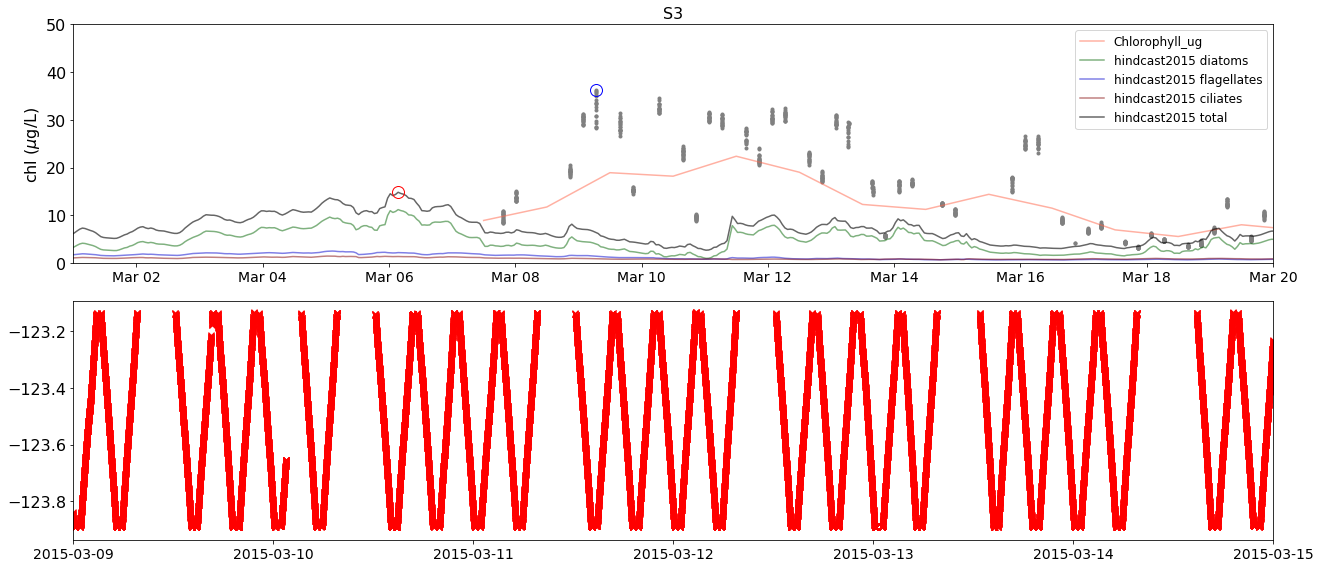

In [25]:
yearsFmt = mdates.DateFormatter('%b %d')
fig,ax=plt.subplots(2,1,figsize=(18,8))
chl_to_n=1.6
pp=dict()
plist=['S3']
for ii in range(0,len(plist)):
    pl=plist[ii]
    if pl=='S3':
        ax[ii].plot(df.loc[iidfnd,['dts']],[float(ik[0]) for ik in df.loc[iidfnd,['Chlorophyll_ug']].values],'.',color='gray')
        ax[ii].plot(dfM['Day'],dfM['Chlorophyll_ug'],'-',color='tomato',alpha=.5)
    pp[ii]=dict()
    for idir in (dirnames[0],):
        f=ff[idir][pl]
        for var in ('diatoms','flagellates','ciliates'):
            try:
                pp[ii][var]=ax[ii].plot(times[idir],chl_to_n*np.sum(f.variables[var][:,:3,0,0]*f.variables['e3t'][:,:3,0,0],1)/np.sum(f.variables['e3t'][:,:3,0,0],1),
                          linestyle=lsty[idir],color=lcol[idir][var],alpha=.5,label=idir+' '+var)
            except:
                pp[ii][var]=ax[ii].plot(times[idir],chl_to_n*np.sum(f.variables[var][:,:3,0,0]*np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1)/np.sum(np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1),
                          linestyle=lsty[idir],color=lcol[idir][var],alpha=.5,label=idir+' '+var)
        try:
            pp[ii]['tot']=ax[ii].plot(times[idir],chl_to_n*np.sum((f.variables['diatoms'][:,:3,0,0]+f.variables['flagellates'][:,:3,0,0]+f.variables['ciliates'][:,:3,0,0])*f.variables['e3t'][:,:3,0,0],1)/np.sum(f.variables['e3t'][:,:3,0,0],1),
                          linestyle=lsty[idir],color='k',alpha=.6,label=idir+' '+'total')
        except:
            pp[ii]['tot']=ax[ii].plot(times[idir],chl_to_n*np.sum((f.variables['diatoms'][:,:3,0,0]+f.variables['flagellates'][:,:3,0,0]+f.variables['ciliates'][:,:3,0,0])*np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1)/np.sum(np.tile(e3t_0[:,:3,0,0],(len(times[idir]),1)),1),
                          linestyle=lsty[idir],color='k',alpha=.6,label=idir+' '+'total')
    ax[ii].set_title(pl)
    ax[ii].set_ylabel('chl ($\mu$g/L)')
    ax[ii].xaxis.set_major_formatter(yearsFmt)
    ax[ii].set_xlim(xl)
    ax[ii].set_ylim(0,40)
    if ii==0:
        ax[0].legend(bbox_to_anchor=(1,1),fontsize=12)

plt.tight_layout()
ax[0].set_ylim(0,50)
ax[0].plot(dt.datetime(2015,3,9,6,40),36.25,'bo',markersize=12, fillstyle='none')
ax[0].plot(dt.datetime(2015,3,6,3,30),14.85,'ro',markersize=12, fillstyle='none')

ax[1].plot(df['dts'],df['Lon'],'rx')
ax[1].set_xlim(dt.datetime(2015,3,9),dt.datetime(2015,3,15))

In [26]:
np.max(df.loc[iidfnd&(df.dts>dt.datetime(2015,3,9))&(df.dts<dt.datetime(2015,3,10)),['Chlorophyll_ug']])

Chlorophyll_ug    36.2516
dtype: float64

In [27]:
times[idir][1530],times[idir][1560]

(datetime.datetime(2015, 3, 5, 18, 30), datetime.datetime(2015, 3, 7, 0, 30))

In [28]:
np.max(chl_to_n*np.sum((f.variables['diatoms'][1530:1560,:3,0,0]+f.variables['flagellates'][1530:1560,:3,0,0]+\
                        f.variables['ciliates'][1530:1560,:3,0,0])*f.variables['e3t'][1530:1560,:3,0,0],1)/np.sum(f.variables['e3t'][1530:1560,:3,0,0],1))

14.850162

### Now look at Sentry Shoal nitrate comparisons

In [29]:
# load Sentry Shoal Nitrate
filepathN = '/ocean/eolson/MEOPAR/obs/Hakai/SentryShoal/Full_SUNA_Processed.mat'

arrays = {}
fSSN = h5py.File(filepathN)
for k, v in fSSN.items():
    arrays[k] = np.array(v)
ssdates = arrays['Full_SUNA_Processed'][0,:]
sstimes = arrays['Full_SUNA_Processed'][1,:]
sstemps = arrays['Full_SUNA_Processed'][2,:]
sssals = arrays['Full_SUNA_Processed'][3,:]
ssnitrate = arrays['Full_SUNA_Processed'][5,:]
ssdatenumber = arrays['Full_SUNA_Processed'][-1, :]
ssbase = dt.datetime(2000, 1, 1)
py_times = np.array([ssbase for i in range(63721)])
for n in range(63721):
    py_times[n] = ((dt.datetime.fromordinal(int(ssdatenumber[n])))
                       + dt.timedelta(days=ssdatenumber[n]%1)
                       - dt.timedelta(days = 366))
ssn = np.ma.masked_invalid(ssnitrate)


In [30]:
iend={'S3':3,'Sentry Shoal':2}

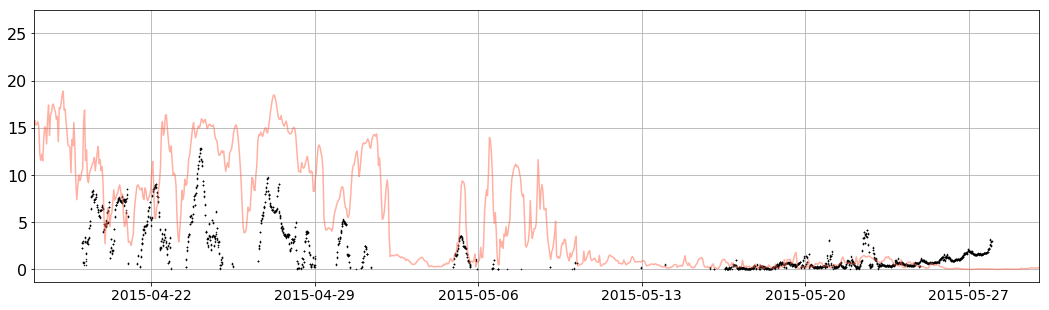

In [31]:
#2015: not enough data 
iiiSS=(py_times>=dt.datetime(2015,3,1))&(py_times<=dt.datetime(2015,6,1))
fig,ax=plt.subplots(1,1,figsize=(18,5))
iax=ax
iax.plot(py_times[iiiSS],ssn[iiiSS],'.',color='k',markersize=1)
fc=ff['hindcast2015']['Sentry Shoal']
rr='Sentry Shoal'
pN,=iax.plot(times['hindcast2015'],
            np.sum(fc.variables['nitrate'][:,:iend[rr],0,0]*fc.variables['e3t'][:,:iend[rr],0,0],1)/np.sum(fc.variables['e3t'][:,:iend[rr],0,0],1),
                linestyle='-',color='tomato',alpha=.5)
iax.set_xlim(dt.datetime(2015,4,17),dt.datetime(2015,5,30))
iax.grid('on')

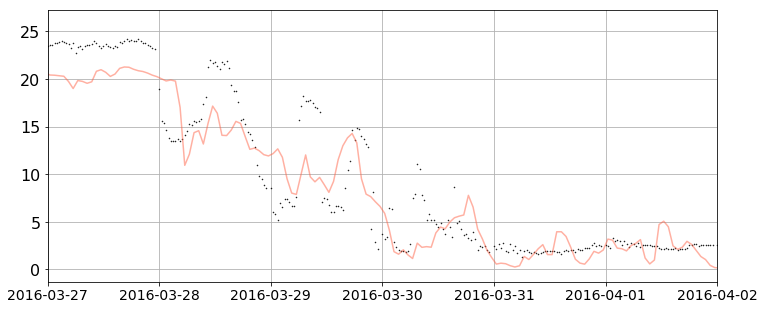

In [32]:
#2016: 
iiiSS=(py_times>=dt.datetime(2016,3,1))&(py_times<=dt.datetime(2016,6,1))
fig,ax=plt.subplots(1,1,figsize=(12,5))
iax=ax
iax.plot(py_times[iiiSS],ssn[iiiSS],'.',color='k',markersize=1)
fc=ff['hindcast2016']['Sentry Shoal']
rr='Sentry Shoal'
pN,=iax.plot(times['hindcast2016'],
            np.sum(fc.variables['nitrate'][:,:iend[rr],0,0]*fc.variables['e3t'][:,:iend[rr],0,0],1)/np.sum(fc.variables['e3t'][:,:iend[rr],0,0],1),
                linestyle='-',color='tomato',alpha=.5)
iax.set_xlim(dt.datetime(2016,3,27),dt.datetime(2016,4,2))
iax.grid('on')

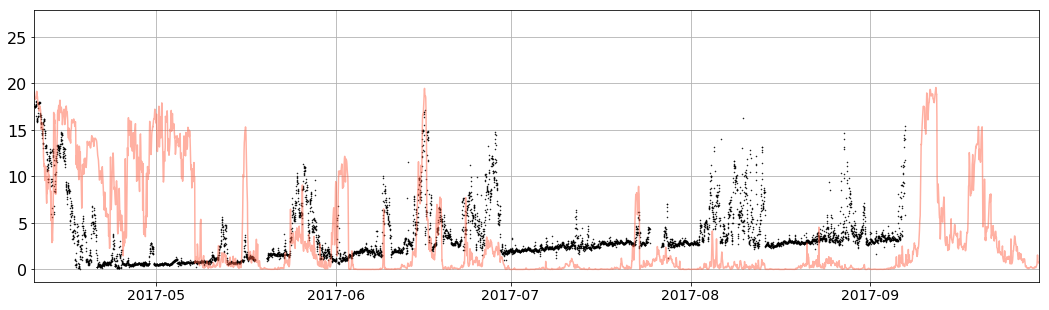

In [33]:
#2017: 
iiiSS=(py_times>=dt.datetime(2017,3,1))&(py_times<=dt.datetime(2017,10,1))
fig,ax=plt.subplots(1,1,figsize=(18,5))
iax=ax
iax.plot(py_times[iiiSS],ssn[iiiSS],'.',color='k',markersize=1)
fc=ff['hindcast2017']['Sentry Shoal']
rr='Sentry Shoal'
pN,=iax.plot(times['hindcast2017'],
            np.sum(fc.variables['nitrate'][:,:iend[rr],0,0]*fc.variables['e3t'][:,:iend[rr],0,0],1)/np.sum(fc.variables['e3t'][:,:iend[rr],0,0],1),
                linestyle='-',color='tomato',alpha=.5)
iax.set_xlim(dt.datetime(2017,4,10),dt.datetime(2017,9,30))
iax.grid('on')